In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set_context('notebook')
import pystan
import stan_utility
import plotting_functions as hierplot
import arviz as az
import patsy
import os
import warnings
warnings.simplefilter('ignore')#removes annoying deprecation warnings
plt.style.use('seaborn-ticks')

order = ["Accuracy","Speed"]
df = pd.read_csv('trimmed_data.csv')
df = df[df.exp==2]
df = df[df.trialType == 'SA']#select trials with single activity only, following analysis are therefore based on these trials only

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


## Checking trimmed data

In [2]:
dfFull = pd.read_csv('../Raw_data/markers/MRK_SAT.csv')
dfFull = dfFull[dfFull.exp==2]

No response :

In [3]:
float(len(dfFull.rt) - len(dfFull[dfFull.trialType != "NR"].rt))/len(dfFull.rt) 

0.009572723765432098

No available EMG and multiple activity trials :

In [4]:
float(len(dfFull[dfFull.trialType != "NR"].rt) - len(dfFull[(dfFull.trialType == "SA")].rt))/ len(dfFull[dfFull.trialType != "NR"].rt)

0.14183810103469263

Fast guesses exclusion by EWMA :

In [5]:
float(len(dfFull[(dfFull.trialType == "SA")].rt) - len(df)) / len(dfFull[(dfFull.trialType == "SA")].rt)

0.07035660586115919

# LME on RT PMT and MT

In [6]:
RT_fit = az.from_netcdf('/media/gabriel/DATA/BU_divers/DecomposingRT_V2_Bayes/Analysis/MixedModels/FittedModels/RT_Exp2_fit.nc')
PMT_fit =  az.from_netcdf('/media/gabriel/DATA/BU_divers/DecomposingRT_V2_Bayes/Analysis/MixedModels/FittedModels/PMT_Exp2_fit.nc')
MT_fit =  az.from_netcdf('/media/gabriel/DATA/BU_divers/DecomposingRT_V2_Bayes/Analysis/MixedModels/FittedModels/MT_Exp2_fit.nc')

In [7]:
az.summary(RT_fit, var_names=["raw_intercept","raw_beta"], round_to=0, credible_interval=.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
raw_intercept,449.0,29.0,393.0,511.0,1.0,1.0,843.0,843.0,835.0,1650.0,1.0
raw_beta[0],160.0,27.0,108.0,213.0,1.0,1.0,1062.0,1062.0,1064.0,1876.0,1.0
raw_beta[1],-94.0,12.0,-118.0,-70.0,0.0,0.0,1177.0,1162.0,1186.0,2095.0,1.0
raw_beta[2],9.0,7.0,-5.0,24.0,0.0,0.0,2549.0,2329.0,2562.0,2864.0,1.0
raw_beta[3],3.0,8.0,-14.0,19.0,0.0,0.0,2365.0,2365.0,2342.0,3037.0,1.0
raw_beta[4],-74.0,8.0,-91.0,-58.0,0.0,0.0,1638.0,1606.0,1669.0,2715.0,1.0
raw_beta[5],77.0,13.0,53.0,102.0,0.0,0.0,1778.0,1772.0,1785.0,3219.0,1.0
raw_beta[6],14.0,13.0,-9.0,40.0,0.0,0.0,3261.0,3261.0,3277.0,4344.0,1.0
raw_beta[7],142.0,27.0,92.0,200.0,1.0,0.0,2146.0,2146.0,2159.0,3667.0,1.0


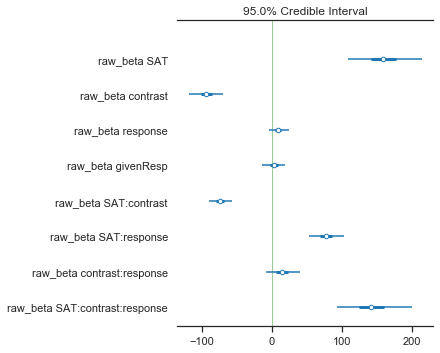

In [8]:
g = az.plot_forest(RT_fit, var_names="raw_beta", credible_interval=0.95, 
                   combined=True, rope=[0,0])
plt.show()


In [9]:
az.summary(PMT_fit, var_names=["raw_intercept","raw_beta"], round_to=0, credible_interval=.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
raw_intercept,368.0,26.0,319.0,417.0,1.0,1.0,664.0,664.0,659.0,1340.0,1.0
raw_beta[0],152.0,27.0,100.0,206.0,1.0,1.0,838.0,832.0,848.0,1175.0,1.0
raw_beta[1],-82.0,11.0,-104.0,-60.0,0.0,0.0,1253.0,1253.0,1272.0,2109.0,1.0
raw_beta[2],-3.0,7.0,-16.0,12.0,0.0,0.0,2146.0,2146.0,2150.0,2763.0,1.0
raw_beta[3],1.0,6.0,-11.0,13.0,0.0,0.0,2638.0,2638.0,2641.0,3608.0,1.0
raw_beta[4],-72.0,8.0,-88.0,-55.0,0.0,0.0,1367.0,1363.0,1371.0,2321.0,1.0
raw_beta[5],82.0,14.0,55.0,110.0,0.0,0.0,1584.0,1564.0,1610.0,2584.0,1.0
raw_beta[6],-5.0,12.0,-28.0,19.0,0.0,0.0,3024.0,3024.0,3068.0,3722.0,1.0
raw_beta[7],158.0,30.0,100.0,218.0,1.0,0.0,2063.0,2060.0,2085.0,3132.0,1.0


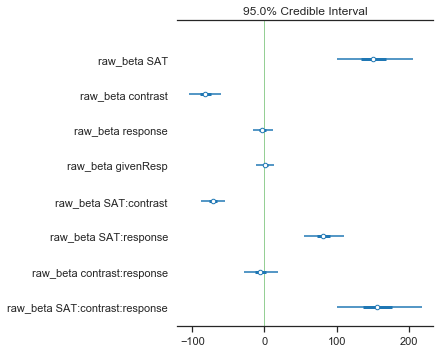

In [10]:
g = az.plot_forest(PMT_fit, var_names="raw_beta", credible_interval=0.95, 
                   combined=True, rope=[0,0])
plt.show()


In [11]:
az.summary(MT_fit, var_names=["raw_intercept","raw_beta"], round_to=0, credible_interval=.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
raw_intercept,72.0,5.0,63.0,83.0,0.0,0.0,701.0,701.0,679.0,1411.0,1.0
raw_beta[0],10.0,2.0,5.0,14.0,0.0,0.0,1018.0,1018.0,1011.0,1758.0,1.0
raw_beta[1],-6.0,1.0,-7.0,-4.0,0.0,0.0,2086.0,2052.0,2101.0,3796.0,1.0
raw_beta[2],5.0,1.0,4.0,7.0,0.0,0.0,2117.0,2117.0,2112.0,3594.0,1.0
raw_beta[3],0.0,3.0,-5.0,6.0,0.0,0.0,2147.0,2147.0,2138.0,2833.0,1.0
raw_beta[4],1.0,1.0,-1.0,3.0,0.0,0.0,6032.0,4724.0,6125.0,4664.0,1.0
raw_beta[5],-3.0,1.0,-5.0,-0.0,0.0,0.0,4205.0,3453.0,4297.0,3586.0,1.0
raw_beta[6],9.0,1.0,6.0,12.0,0.0,0.0,2747.0,2675.0,2801.0,3986.0,1.0
raw_beta[7],-5.0,2.0,-9.0,-1.0,0.0,0.0,5710.0,4836.0,5751.0,4407.0,1.0


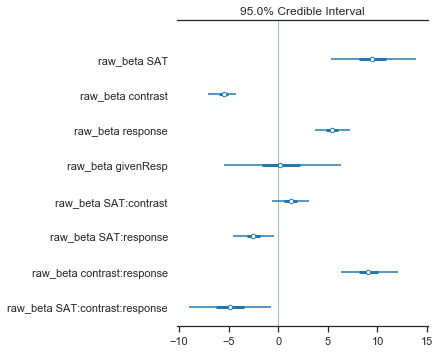

In [12]:
g = az.plot_forest(MT_fit, var_names="raw_beta", credible_interval=0.95, 
                   combined=True, rope=[0,0])
plt.show()


# GLME on precision

In [13]:
Precision_fit = az.from_netcdf('/media/gabriel/DATA/BU_divers/DecomposingRT_V2_Bayes/Analysis/MixedModels/FittedModels/Precision_Exp2_fit.nc')

In [14]:
az.summary(Precision_fit, var_names=["raw_intercept","raw_beta"], round_to=2, credible_interval=.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
raw_intercept,0.75,0.06,0.63,0.86,0.0,0.0,731.47,708.15,656.55,493.31,1.01
raw_beta[0],0.12,0.03,0.07,0.18,0.0,0.0,956.17,956.17,918.80,1634.85,1.00
raw_beta[1],0.18,0.03,0.13,0.23,0.0,0.0,1339.66,1284.18,1341.26,1638.66,1.00
raw_beta[2],-0.01,0.03,-0.07,0.05,0.0,0.0,2300.91,1849.33,2479.13,2324.26,1.00
raw_beta[3],0.17,0.04,0.10,0.25,0.0,0.0,953.75,953.75,912.04,1771.12,1.00


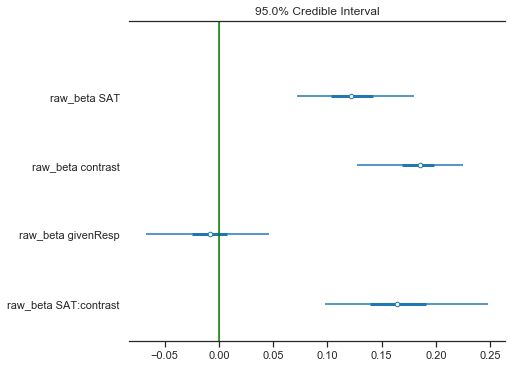

In [15]:
g = az.plot_forest(Precision_fit, var_names="raw_beta", credible_interval=0.95, 
                   combined=True, figsize=(7,5), rope=(0,0))
plt.vlines(0, -1, 10, 'g')
plt.show()


# Plotting raw effects on RT, PMT and MT

In [16]:
def std_within(df, dv, cond,unit):#Normalize according to cousineau's method, not really optimized...
    for i, con_dat in df.groupby(cond):
        grd_avrg = con_dat[dv].mean()
        for xx, sub_dat in con_dat.groupby(unit):
            sub_avrg = sub_dat[dv].mean()
            sub_dat['corrected'] = sub_dat.apply(lambda row: row[dv] - sub_avrg + grd_avrg, axis=1)
            df.loc[(df[cond[0]]==i[0])&(df[cond[1]]==i[1])&(df[unit]==xx), 'corrected%s' %dv]  = sub_dat['corrected']
std_within(df,'mt',['condition','contraste'],'participant')
std_within(df,'pmt',['condition','contraste'],'participant')
std_within(df,'rt',['condition','contraste'],'participant')

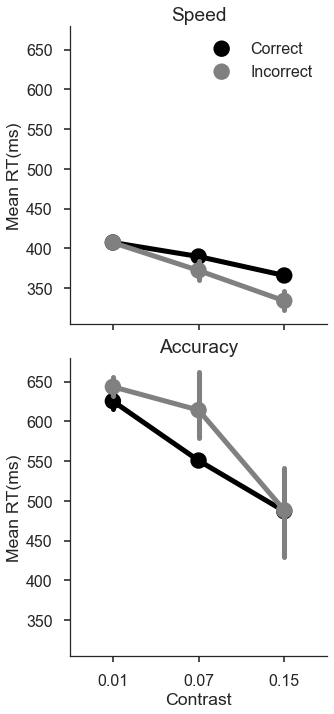

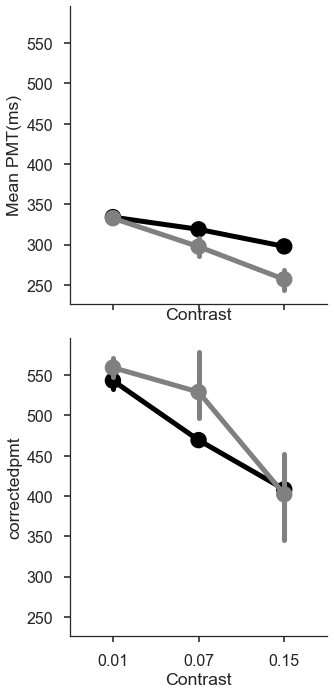

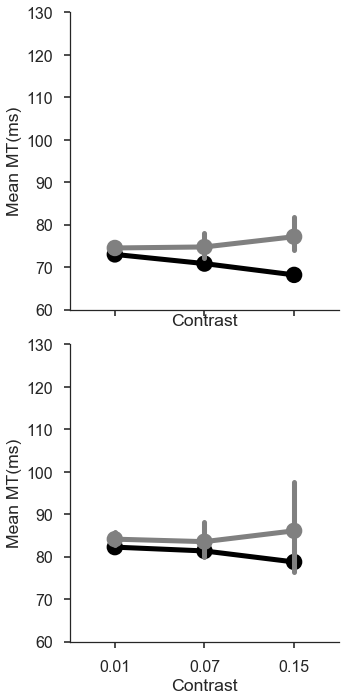

In [17]:
plt.style.use("seaborn-poster")
df['Response'] = df.apply(lambda row: 'Correct' if row['response']==1 else 'Incorrect', axis = 1)

g = sns.factorplot(x='contraste', y='correctedrt', units='participant', row='condition', hue='Response',data=df, palette=['k','gray'], dpi=300)
g.set(title="", xlabel="Contrast")
titles = ["Speed","Accuracy"]
i = 0
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    ax.set_ylabel('Mean RT(ms)')
    if i == 0:
        ax.set_xlabel("")
        ax.legend()
        i += 1
g._legend.remove()
plt.show()

g = sns.factorplot(x='contraste', y='correctedpmt', units='participant', row='condition', hue='Response',data=df, palette=['k','gray'])
g.set(title="", xlabel="Contrast")
i = 0
for ax, title in zip(g.axes.flat, titles):
    if i == 0:
        ax.set_ylabel('Mean PMT(ms)')
        i += 1
    else :
        ax.set_xlabel('Contrast')
g._legend.remove()
plt.show()

g = sns.factorplot(x='contraste', y='correctedmt', units='participant', row='condition', hue='Response',data=df, palette=['k','gray'])
g.set(title="", xlabel="Contrast")
i = 0
for ax, title in zip(g.axes.flat, titles):
    ax.set_ylabel('Mean MT(ms)')
    i += 1
    ax.set_ylim(60,130)
g._legend.remove()
plt.show()



# Combining exp1 and exp2 LME plot

In [18]:
RT_fit1 = az.from_netcdf('/media/gabriel/DATA/BU_divers/DecomposingRT_V2_Bayes/Analysis/MixedModels/FittedModels/RT_Exp1_fit.nc')
PMT_fit1 =  az.from_netcdf('/media/gabriel/DATA/BU_divers/DecomposingRT_V2_Bayes/Analysis/MixedModels/FittedModels/PMT_Exp1_fit.nc')
MT_fit1 =  az.from_netcdf('/media/gabriel/DATA/BU_divers/DecomposingRT_V2_Bayes/Analysis/MixedModels/FittedModels/MT_Exp1_fit.nc')

In [19]:
RT_fit.posterior.coords["b"] = ["SAT", "Contrast", "Correctness", "Resp. Side", r"SAT $\times$ Contrast",
                                r"SAT $\times$ Corr.", r"Contr. $\times$ Corr.", r"SAT $\times$ Contr. $\times$ Corr."]
RT_fit1.posterior.coords["b"] = ["SAT", "Contrast", "Correctness", "Resp. Side", r"SAT $\times$ Contrast",
                                r"SAT $\times$ Corr.", r"Contr. $\times$ Corr.", r"SAT $\times$ Contr. $\times$ Corr."]

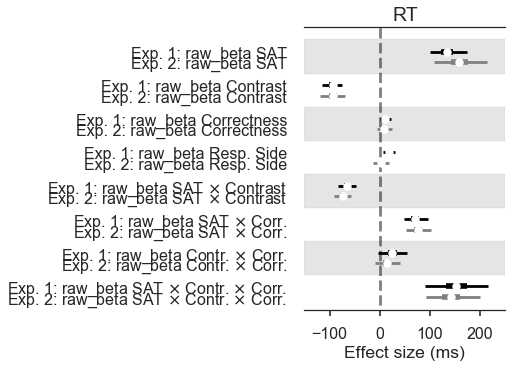

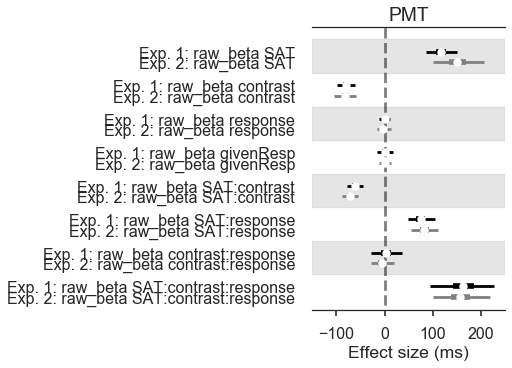

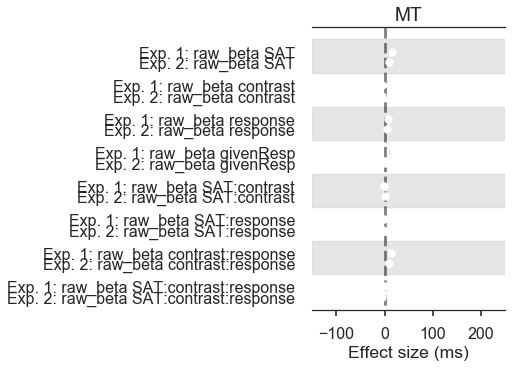

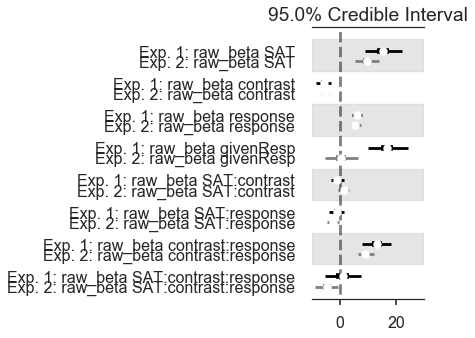

In [20]:
g = az.plot_forest([RT_fit1, RT_fit], model_names=["Exp. 1", "Exp. 2"], var_names="raw_beta", 
                   credible_interval=0.95, combined=True, rope=None, figsize=(7,5), colors=('k', 'gray'))
plt.vlines(0, -1, 13, ls="--", alpha=.5)
plt.xlim(-150, 250)
plt.xlabel('Effect size (ms)')
plt.title('RT')
plt.savefig("../Manuscript/plots/LMERT.png", dpi=300)
g = az.plot_forest([PMT_fit1, PMT_fit], model_names=["Exp. 1", "Exp. 2"], var_names="raw_beta", 
                   credible_interval=0.95, combined=True, rope=None, figsize=(7,5), colors=('k', 'gray'))
plt.vlines(0, -1, 13, ls="--", alpha=.5)
plt.xlim(-150, 250)
plt.xlabel('Effect size (ms)')
plt.title('PMT')
plt.savefig("../Manuscript/plots/LMEPMT.png", dpi=300)
g = az.plot_forest([MT_fit1, MT_fit], model_names=["Exp. 1", "Exp. 2"], var_names="raw_beta", 
                   credible_interval=0.95, combined=True, rope=None, figsize=(7,5), colors=('k', 'gray'))
plt.vlines(0, -1, 13, ls="--", alpha=.5)
plt.xlim(-150, 250)
plt.xlabel('Effect size (ms)')
plt.title('MT')
plt.savefig("../Manuscript/plots/LMEMT.png", dpi=300)
g = az.plot_forest([MT_fit1, MT_fit], model_names=["Exp. 1", "Exp. 2"], var_names="raw_beta", 
                   credible_interval=0.95, combined=True, rope=None, figsize=(2,5), colors=('k', 'gray'))
plt.vlines(0, -1, 13, ls="--", alpha=.5)
plt.xlim(-10, 30)
plt.savefig("../Manuscript/plots/LMEMTzoom.png", dpi=300)
plt.show()


# Frequentist replication

In [ ]:
%load_ext rpy2.ipython

/home/gabriel/anaconda3/envs/decomp/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Le chargement a nécessité le package : Matrix

  warnings.warn(x, RRuntimeWarning)
/home/gabriel/anaconda3/envs/decomp/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Le chargement a nécessité le package : carData

  warnings.warn(x, RRuntimeWarning)
/home/gabriel/anaconda3/envs/decomp/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: boundary (singular) fit: see ?isSingular

  warnings.warn(x, RRuntimeWarning)


Linear mixed model fit by REML ['lmerMod']
Formula: logrt ~ contraste.c * sResponse * SATcoded + GRcoded + (contraste.c *  
    sResponse * SATcoded + GRcoded | participant)
   Data: df1

REML criterion at convergence: 7092.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3993 -0.6709 -0.1349  0.5330  4.5583 

Random effects:
 Groups      Name                           Variance Std.Dev. Corr             
 participant (Intercept)                    0.041740 0.20430                   
             contraste.c                    0.003131 0.05595   0.08            
             sResponse                      0.002791 0.05283   0.34 -0.40      
             SATcoded                       0.025386 0.15933   0.08  0.38 -0.01
             GRcoded                        0.003191 0.05649   0.10 -0.02  0.47
             contraste.c:sResponse          0.003392 0.05824   0.30 -0.10  0.93
             contraste.c:SATcoded           0.001063 0.03260   0.14 -0.30  0.10
             sR

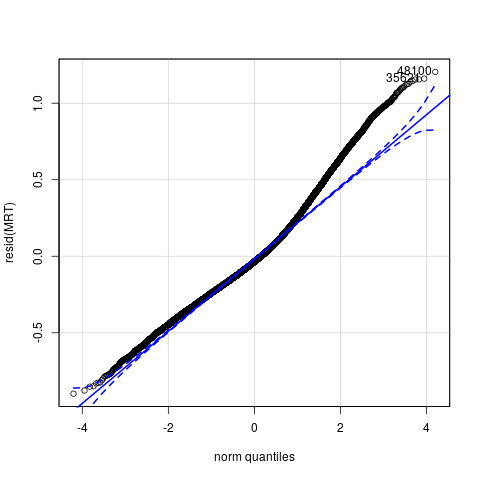

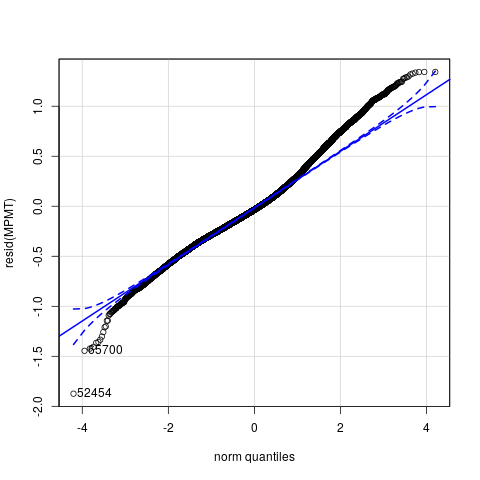

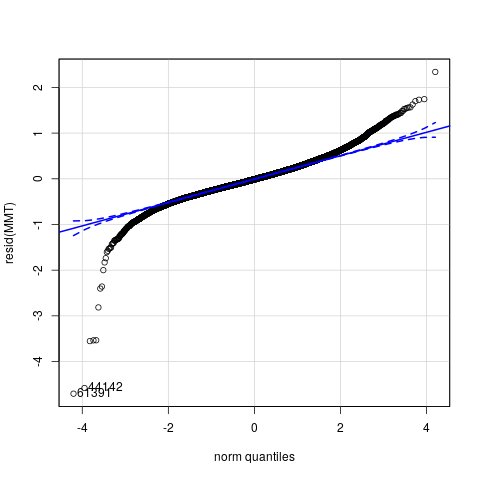

In [2]:
%%R 
library(lme4)
library(xtable)
library(car)
df = read.csv('trimmed_data.csv')

df1 = df[df$exp == 2,]
df2 = df1[df1$trialType == "SA",]
df1 = df1[complete.cases(df1$rt), ]

#Coding
df1$SATcoded <-ifelse(df1$condition=="Speed",-0.5,0.5) #Sum coding
df1$GRcoded<-ifelse(df1$givenResp=="Right",-0.5,0.5)#Sum coding
df1$contraste.c<- (df1$contraste - 0.07)*10 # Centering on mid contrast value and rescaling for ease of slope interpretation
df1$sResponse<-ifelse(df1$response==1,0,1)#Treatment coding

### Log transform
df1$logrt = log(df1$rtMNE)
df1$logpmt = log(df1$pmt)
df1$logmt = log(df1$mt)

### Models + residual check
# Uncomment qqPlot and print(confint()) to see residual QQPlots and CI around estimates

MRT <- lmer(logrt ~ contraste.c * sResponse * SATcoded + GRcoded +
              (contraste.c * sResponse * SATcoded + GRcoded|participant), data=df1, REML=TRUE)
print(summary(MRT))


MPMT <- lmer(logpmt ~ contraste.c * sResponse * SATcoded+ GRcoded  +
               (contraste.c * sResponse * SATcoded + GRcoded|participant), data=df1, REML=TRUE)
print(summary(MPMT))

MMT <- lmer(logmt ~ SATcoded * contraste.c * sResponse+ GRcoded  +
              (contraste.c * sResponse * SATcoded + GRcoded|participant), data=df1, REML=TRUE)
print(summary(MMT))

# GLME on precision

In [3]:
%%R 
MPrec <- glmer(response ~ SATcoded * contraste.c + GRcoded +
                          (SATcoded + GRcoded|participant), family="binomial", data=df1)
print(summary(MPrec))
#print(confint(MPrec, method="Wald"))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response ~ SATcoded * contraste.c + GRcoded + (SATcoded + GRcoded |  
    participant)
   Data: df1

     AIC      BIC   logLik deviance df.resid 
 31424.1  31518.1 -15701.1  31402.1    37990 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.3828   0.0906   0.2842   0.4934   1.3597 

Random effects:
 Groups      Name        Variance Std.Dev. Corr       
 participant (Intercept) 0.05613  0.2369              
             SATcoded    0.06197  0.2489   -0.51      
             GRcoded     0.07319  0.2705    0.30 -0.04
Number of obs: 38001, groups:  participant, 16

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           1.73282    0.06240  27.772   <2e-16 ***
SATcoded              0.89172    0.07328  12.169   <2e-16 ***
contraste.c           2.42590    0.03733  64.980   <2e-16 ***
GRcoded        

# Means


In [21]:
means = df[df.response == 1].groupby(["contraste","condition"]).mean().reset_index()

In [22]:
wideRT = pd.pivot_table(means, values='rt', index=['contraste'],
                    columns=['condition'], aggfunc=np.mean).T.round(0)
print(wideRT)

contraste   0.01   0.07   0.15
condition                     
Accuracy   628.0  551.0  487.0
Speed      407.0  393.0  366.0


In [23]:
widePMT = pd.pivot_table(means, values='pmt', index=['contraste'],
                    columns=['condition'], aggfunc=np.mean).T.round(0)
print(widePMT)

contraste   0.01   0.07   0.15
condition                     
Accuracy   545.0  470.0  408.0
Speed      334.0  322.0  299.0


In [24]:
wideMT = pd.pivot_table(means, values='mt', index=['contraste'],
                    columns=['condition'], aggfunc=np.mean).T.round(0)
print(wideMT)

contraste  0.01  0.07  0.15
condition                  
Accuracy   82.0  81.0  79.0
Speed      73.0  71.0  68.0
